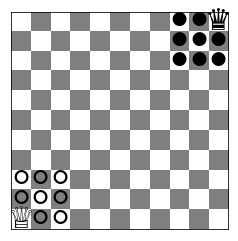

In [54]:
from operator import add
from enum import Enum
import random

import matplotlib.pyplot as plt
import numpy as np

# Positions are defined as a tuple of two elements: (x,y)
# Boards are defined as a tuple of four elements:
# - White queen position
# - White pawns as as set of positions
# - Black queen position
# - Black pawns as as set of positions

class Turn(Enum):
    WHITE = 1
    BLACK = 2

class Board:
    
    def __init__(self, verbose=False):
        self.white_pawns = set(x for x in [(8,0),(8,1),(8,2),(9,0),(9,1),(9,2),(10,1),(10,2)])
        self.white_queen = (10,0)
        self.white_queen_shield = set(x for x in [(9,0),(9,1),(10,1)])
        self.black_pawns = set(x for x in [(0,8),(0,9),(1,8),(1,9),(1,10),(2,8),(2,9),(2,10)])
        self.black_queen = (0,10)
        self.black_queen_shield = set(x for x in [(0,1),(1,1),(1,0)])
        self.turn = Turn.WHITE
        self.verbose = verbose

    # def __init__(self, board, turn):
    #     self.set_board(board, turn)

    @staticmethod
    def winning_position(board):
        if board[0] == (0,10):
            return 1
        if board[2] == (10,0):
            return -1
        return 0
    
    # @staticmethod
    # def draw_board(white_pieces, black_pices):

        # Create board and colors
        board = np.zeros((11,11,3))
        board += 0.5 
        board[::2, ::2] = 1 
        board[1::2, 1::2] = 1

        _, ax = plt.subplots()
        ax.imshow(board, interpolation='nearest')

        white_queen = white_pieces.pop(0)
        ax.text(white_queen[1], white_queen[0], u'\u2655', size=30, ha='center', va='center')

        for y, x in white_pieces:
            ax.text(x, y, u'\u26aa', size=30, ha='center', va='center')

        black_queen = black_pices.pop(0)
        ax.text(black_queen[1], black_queen[0], u'\u265b', size=30, ha='center', va='center')

        for y, x in black_pices:
            ax.text(x, y, u'\u26ab', size=30, ha='center', va='center')

        ax.set(xticks=[], yticks=[])
        ax.axis('image')

        plt.show()
    
    @staticmethod
    def draw_board(b):

        # Create board and colors
        board = np.zeros((11,11,3))
        board += 0.5 
        board[::2, ::2] = 1 
        board[1::2, 1::2] = 1

        _, ax = plt.subplots()
        ax.imshow(board, interpolation='nearest')

        white_queen = b[0]
        ax.text(white_queen[1], white_queen[0], u'\u2655', size=30, ha='center', va='center')

        for y, x in b[1]:
            ax.text(x, y, u'\u26aa', size=30, ha='center', va='center')

        black_queen = b[2]
        ax.text(black_queen[1], black_queen[0], u'\u265b', size=30, ha='center', va='center')

        for y, x in b[3]:
            ax.text(x, y, u'\u26ab', size=30, ha='center', va='center')

        ax.set(xticks=[], yticks=[])
        ax.axis('image')

        plt.show()

    def set_board(self, board, turn):
        self.white_queen = board[0]
        self.white_pawns = board[1]
        self.white_queen_shield = self.update_queen_shield(self.white_queen)
        self.black_queen = board[2]
        self.black_pawns = board[3]
        self.black_queen_shield = self.update_queen_shield(self.black_queen)
        self.turn = turn

    def get_board(self):
        #return(([self.white_queen] + list(self.white_pawns)),[self.black_queen] + list(self.black_pawns))
        return (self.white_queen,self.white_pawns,self.black_queen, self.black_pawns)

    def update_queen_shield(self, queen_position):
        moves = [(-1,0),(-1,1),(0,1),(1,1),(1,0),(1,-1),(0,-1),(-1,-1)]
        return set([ tuple(map(add, move, queen_position)) for move in moves])
    
    def current_postions(self):
        return (self.white_positions, self.black_positions)
    
    def white_pawn_moves(self, pawn):

        moves = []
        
        if pawn[0] > 0:
            moves.append((pawn[0] - 1, pawn[1]))
        if pawn[1] < 10:
            moves.append((pawn[0], pawn[1] + 1))
            
        return moves
    
    def black_pawn_moves(self, pawn):
        
        moves = []
        
        if pawn[0] < 10:
            moves.append((pawn[0] + 1, pawn[1]))
        if pawn[1] > 0:
            moves.append((pawn[0], pawn[1] - 1))
            
        return moves
    
    def pawn_moves(self, pawn, turn):

        moves = []

        if turn == Turn.WHITE:
            if pawn[0] > 0:
                moves.append((pawn[0] - 1, pawn[1]))
            if pawn[1] < 10:
                moves.append((pawn[0], pawn[1] + 1))
        else:
            if pawn[0] < 10:
                moves.append((pawn[0] + 1, pawn[1]))
            if pawn[1] > 0:
                moves.append((pawn[0], pawn[1] - 1))

        return moves

    def queen_moves(self, board, turn):

        boards = []

        white_queen = board[0]
        white_pawns = board[1]
        white_queen_shield = self.update_queen_shield(white_queen)
        black_queen = board[2]
        black_pawns = board[3]
        black_queen_shield = self.update_queen_shield(black_queen)

        if turn == Turn.WHITE:
            queen = white_queen
            your_pawns = white_pawns
            oponent_pawns = black_pawns
            directions = [(-1,0),(0,1)]
            #queen_shield = white_queen_shield
            opponent_queen_shield = black_queen_shield
        else:
            queen = black_queen        
            your_pawns = black_pawns
            oponent_pawns = white_pawns
            directions = [(1,0),(0,-1)]
            #queen_shield = black_queen_shield
            opponent_queen_shield = white_queen_shield

        for direction in directions:
            
            x_move = direction[0] + queen[0]
            y_move = direction[1] + queen[1]

            while (x_move,y_move) in your_pawns:

                x_move = direction[0] + x_move
                y_move = direction[1] + y_move

            queen_shield = self.update_queen_shield((x_move, y_move))

            if  0 <= x_move <= 10 and \
                0 <= y_move <= 10 and \
                len(queen_shield.intersection(oponent_pawns)) == 0 and \
                len(queen_shield.intersection(opponent_queen_shield)) == 0:
                    if turn == Turn.WHITE:
                        boards.append(((x_move,y_move),white_pawns,black_queen,black_pawns))
                    else:
                        boards.append((white_queen,white_pawns,(x_move,y_move),black_pawns))

        return boards
    
    def next_boards(self, board, turn):
        
        boards = []
        
        white_queen = board[0]
        white_pawns = board[1]
        white_queen_shield = self.update_queen_shield(white_queen)
        black_queen = board[2]
        black_pawns = board[3]
        black_queen_shield = self.update_queen_shield(black_queen)
        
        if turn == Turn.WHITE:
            # Pawns move
            for pawn in white_pawns:    
                pawn_moves = self.white_pawn_moves(pawn)
                for pawn_move in pawn_moves:
                    if  pawn_move != (0,10) and \
                        pawn_move not in white_pawns and \
                        pawn_move != white_queen and \
                        pawn_move not in black_queen_shield:
                            
                            new_white_pawns = white_pawns.copy()
                            new_black_pawns = black_pawns.copy() 
                            
                            if pawn_move in black_pawns:
                                # Remove the killed black pawn if exists
                                new_black_pawns.remove(pawn_move)
                                #new_black_pawns = black_pawns.copy()

                            # Move the white pawn
                            new_white_pawns.remove(pawn)
                            new_white_pawns.add(pawn_move)
                    
                            boards.append((white_queen,new_white_pawns,black_queen,new_black_pawns))
        else:
            for pawn in black_pawns:    
                pawn_moves = self.black_pawn_moves(pawn)
                for pawn_move in pawn_moves:
                    if  pawn_move != (10,0) and \
                        pawn_move not in black_pawns and \
                        pawn_move != black_queen and \
                        pawn_move not in white_queen_shield:
                            
                            new_black_pawns = black_pawns.copy()
                            new_white_pawns = white_pawns.copy() 
                            
                            if pawn_move in white_pawns:
                                # Remove the killed white pawn if exists
                                new_white_pawns.remove(pawn_move)
                                #new_white_pawns = white_pawns.copy()

                            # Move the black pawn
                            new_black_pawns.remove(pawn)
                            new_black_pawns.add(pawn_move)
                    
                            boards.append((white_queen,new_white_pawns,black_queen,new_black_pawns))
        
        boards = boards + self.queen_moves(board, turn)
        return boards
    
    def simulate(self, board, turn):

        #board = self.get_board()
        #turn = self.turn
    
        while (result := Board.winning_position(board)) == 0:

            next_moves = self.next_boards(board, turn)
            if len(next_moves) == 0:
                return 0
            
            if self.verbose:
                print(turn)

            turn = Turn.BLACK if turn == Turn.WHITE else Turn.WHITE
            board = random.choice(next_moves)
            if self.verbose:
                print(board)
                Board.draw_board(board)

        return result 
        
white_positions = [(10,0),(8,0),(8,1),(8,2),(9,0),(9,1),(9,2),(10,1),(10,2)]
black_positions = [(0,10),(0,8),(0,9),(1,8),(1,9),(1,10),(2,8),(2,9),(2,10)]

white_queen = (10,0)
white_pawns = frozenset([(8,0),(8,1),(8,2),(9,0),(9,1),(9,2),(10,1),(10,2)])
black_queen = (0,10)
black_pawns = frozenset([(0,8),(0,9),(1,8),(1,9),(1,10),(2,8),(2,9),(2,10)])

board = (white_queen, white_pawns, black_queen, black_pawns)

Board.draw_board(board)
         


In [92]:
# board = ((8, 7), {(7, 4), (4, 0), (7, 1), (9, 3), (3, 1), (4, 6), (8, 3), (6, 0)}, (2, 5), {(0, 7), (3, 8), (3, 4), (2, 7), (4, 9), (6, 8), (6, 6), (4, 7)})

b = Board(verbose=False)
b.simulate(b.get_board(), Turn.WHITE)

-1

In [15]:
from collections import defaultdict

# class mcts:
    
#     def __init__(self):
#         self.children = defaultdict(list)
#         self.Q = defaultdict(int)
#         self.N = defaultdict(int)

#     def isLeaf(self, node):
#         return not node in self.children
    
#     def selection(self, node):
#         if self.isLeaf(node):
#             result = self.board.simulate()
#             next_boards = self.board.

#         else:
#             return node
    
#     def simulation(self, node):


#     def expansion(self, node):
#         self.children[node.get_board()] = node.next_boards()

#     def simulation(self, node):
        


#     # def best_move(board, turn):
        

In [20]:
# b = Board()
# board = b.get_board()
# Board.draw_board(board)

# new_boards = b.next_boards(board, Turn.BLACK)

# for nb in new_boards:
#     Board.draw_board(nb)


In [13]:
board

((10, 0),
 {(8, 0), (8, 1), (8, 2), (9, 0), (9, 1), (9, 2), (10, 1), (10, 2)},
 (0, 10),
 {(0, 8), (0, 9), (1, 8), (1, 9), (1, 10), (2, 8), (2, 9), (2, 10)})

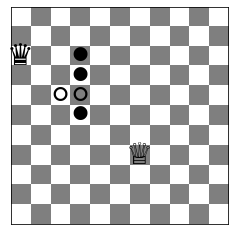

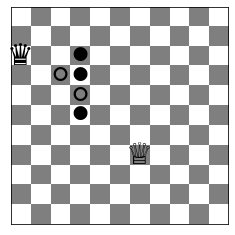

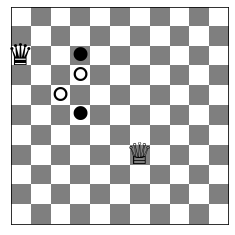

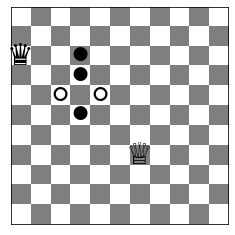

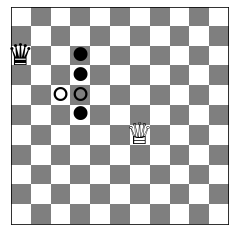

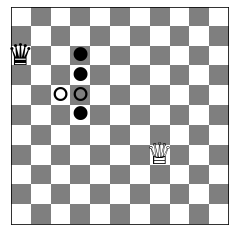

In [50]:
b = Board(verbose=True)

board = ((7, 6), {(4, 3), (4, 2)}, (2, 0), {(2, 3), (3, 3), (5, 3)})
Board.draw_board(board)

new_boards = b.next_boards(board, Turn.WHITE)

for nb in new_boards:
    Board.draw_board(nb)

In [5]:
b.set_board(
    ((10, 0), {(9, 0), (8, 1), (10, 1), (3, 10), (8, 0), (8, 2), (9, 1), (10, 2)}), ((0, 10), {(2, 10), (3, 8), (0, 9), (0, 8), (1, 9), (2, 8)}), 
    Turn.BLACK)

white_pieces, black_pieces = b.get_board()
board.draw_board([white_pieces[0]] + list(white_pieces[1]), [black_pieces[0]] + list(black_pieces[1]))

new_boards = b.next_boards()

for b in new_boards:
    board.draw_board([b[0]] + list(b[1]), [b[2]] + list(b[3]))

TypeError: set_board() takes 3 positional arguments but 4 were given

(0, 10)


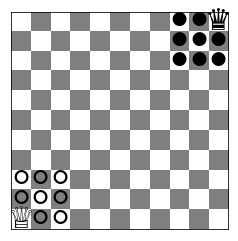

In [ ]:
b = board()
pieces = b.get_board()
board.draw_board(pieces[0], pieces[1])
b.set_board(pieces[0], pieces[1], Turn.WHITE)
print(b.next_boards())

In [15]:
from dataclasses import dataclass

@dataclass(frozen=True, eq=True)        
class Transaction:
    __slots__ = ['sender', 'receiver']
    sender: int
    receiver: int

In [16]:
r = Transaction(1,2)
print(r)

Transaction(sender=1, receiver=2)


In [17]:
d = dict()
d[r] = 2

In [13]:
s = set([1,2,3])
t = (s,(1,2))
d = {t:1}

print(d)

s = frozenset([1,2,4])

print(d)

t = (s,(1,3))

print(d)

d = {t:1}

print(d)

TypeError: unhashable type: 'set'